In [1]:
# Imports
from __future__ import division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.optimize as opt
from mpl_toolkits.mplot3d import Axes3D, proj3d
from matplotlib.colors import LogNorm


# Magics
%matplotlib inline

/home/matthewmckay/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Optimization: An Introduction to the Nelder-Mead Algorithm

### Author: Chase Coleman

One of the most used optimization algorithms of today is the Nelder-Mead algorithm.  It has become a core muscle in many programming languages' minimization techniques, including being the default for both Matlab and Scipy's `fmin` function.  One of its key benefits is that it requires no information about first or second derivatives.  The Nelder-Mead algorithm searches for the minimum value of an objective function map $f : \mathbb{R}^{n} \rightarrow \mathbb{R}$ by applying simple operations to a simplex of $n+1$ points in $\mathbb{R}^n$.  The algorithm is simple and a basic understanding of it can provide valuable intuition for when it is (and more importantly when it isn't) an appropriate minimization technique.  


## Key Components of the Algorithm

The algorithm relies on 4 main operations on a simplex of points.  Before presenting the main algorithm, we will discuss these operations to simplify the process later.  The four operations are:

* Reflection
* Expansion
* Contraction
* Shrink

We will discuss these operations in the context of a concrete example.  Consider the following simplex of points in 2-D.  Let $\Delta$ be a simplex that consists of the points $x_1 = (0, 0); x_2 = (2, 3); x_3 = (4, 0)$.  We can then compute the center of mass $\bar{x} = \frac{1}{3} \sum_{i=1}^3 x_i = (2, 1)$.  We graph the points of our simplex and their center of mass below.

/home/matthewmckay/anaconda/lib/python3.5/site-packages/matplotlib/text.py:2046: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


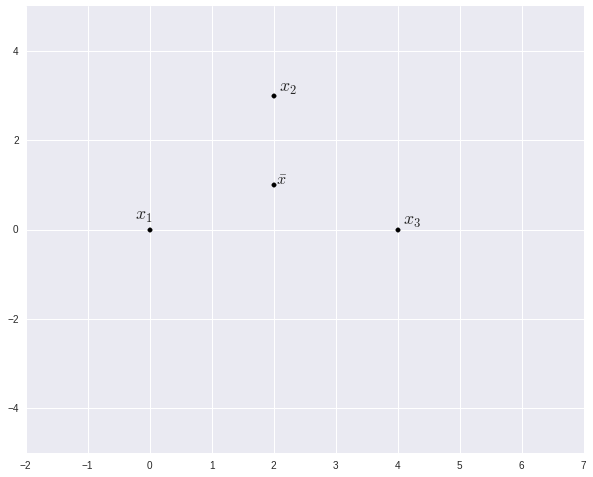

In [2]:
alpha, beta, gamma, delta = 1., 2., .5, .75
x1, x2, x3 = np.array([0., 0.]), np.array([2., 3.]), np.array([4., 0.])
xbar = np.array([2, 1])
Delta = np.vstack([x1, x2, x3])
offsets = [(-15, 10), (5, 5), (5, 5)]

# init_simplex = Polygon(Delta, closed=True)
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.set_xlim((-2, 7))
ax.set_ylim((-5, 5))


for ind, point in enumerate(Delta):
    curr_x = r"$x_{}$"
    curr_offset = offsets[ind]
    ax.scatter(point[0], point[1], color="k")
    ax.annotate(curr_x.format(ind+1), xy=point, xytext=curr_offset, 
                textcoords='offset points', size=18)
    
ax.scatter(xbar[0], xbar[1], color="k")
ax.annotate(r"$\bar{x}$", xy=xbar, textcoords='offset points', size=16)

plt.show(fig)

To facilitate a simple description of these operations, we sweep several formalities under the rug.  First, the point that has these operations applied to it is chosen within the algorithm, but we simply perform all of our operations on $x_2$.  Second, and perhaps more importantly, the center of mass used within the algorithm is not the center of mass of all $n+1$ points (it is the center of mass of $n$ points where we exclude the point for which the function ahieves the highest value).  Also for aesthetic purposes, we use some nonstandard parameter values in the graphing of these operations ($\alpha = 1$, $\beta = 2$, $\gamma=.5$, and $\delta=.75$).

### Reflection

The reflection operation creates a new point defined by reflecting a point across the center of mass of the simplex by $x_r := \bar{x} + \alpha (\bar{x} - x_i)$, where $x_i$ is the point we are reflecting.  Thus in our example, $x_r = \bar{x} + \alpha (\bar{x} - x_2) = (2, 1) + \alpha \left( (2, 1) - (2, 3) \right) = (2, -1)$.  We add the reflected point below.

/home/matthewmckay/anaconda/lib/python3.5/site-packages/matplotlib/text.py:2046: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


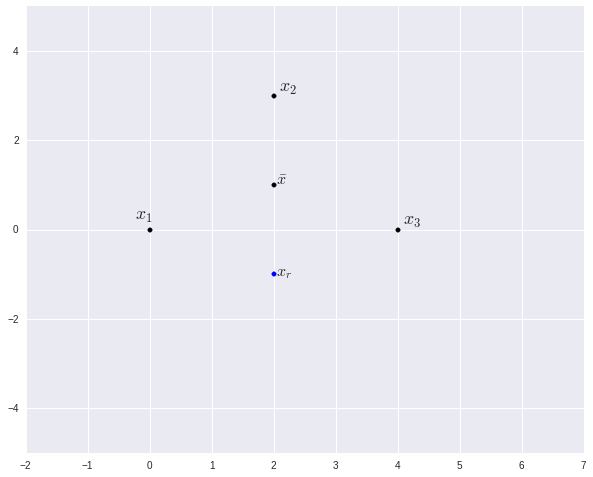

In [3]:
xr = xbar + alpha*(xbar - x2)

ax.scatter(xr[0], xr[1], color="b")
ax.annotate(r"$x_r$", xy=xr, textcoords='offset points', size=16)

fig

### Expansion
The expansion operation creates a new point by expanding the reflected point further away from $\bar{x}$.  It is created by $x_e := \bar{x} + \beta (x_r - \bar{x})$.  We can see in our example that $x_e = \bar{x} + \beta (x_r - \bar{x}) = (2, 1) + \beta \left( (2, -1) - (2, 1) \right) = (2, -3)$.  We add the expanded point below.

/home/matthewmckay/anaconda/lib/python3.5/site-packages/matplotlib/text.py:2046: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


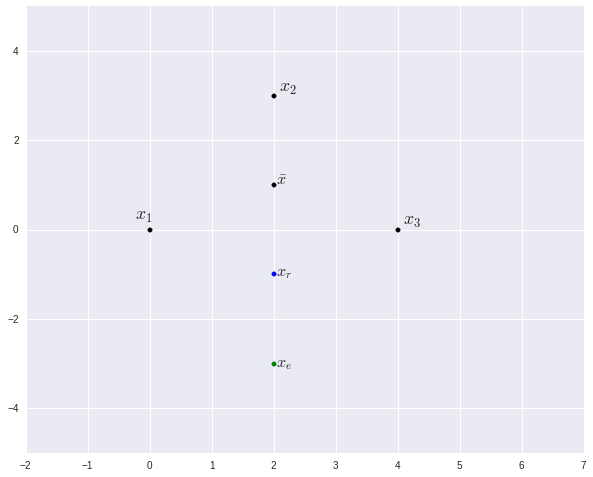

In [4]:
xe = xbar + beta*(xr - xbar)

ax.scatter(xe[0], xe[1], color="g")
ax.annotate(r"$x_e$", xy=xe, textcoords='offset points', size=16)

fig

### Contraction

There are two types of contractions: outside and inside.  The operation of contraction is the opposite of the operation expanding in the sense that instead of expanded the reflected point out further, it draws it closer towards the center of mass.

The outside contraction creates a new point by contracting towards the center of mass from the reflected point and is defined by $x_{oc} = \bar{x} + \gamma (x_r - \bar{x})$.

The inside contaction creates a new point by contracting towards the center of mass from the point $x_i$ that we reflected on and is defined by $x_{ic} = \bar{x} + \gamma (x_r - \bar{x})$.

/home/matthewmckay/anaconda/lib/python3.5/site-packages/matplotlib/text.py:2046: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


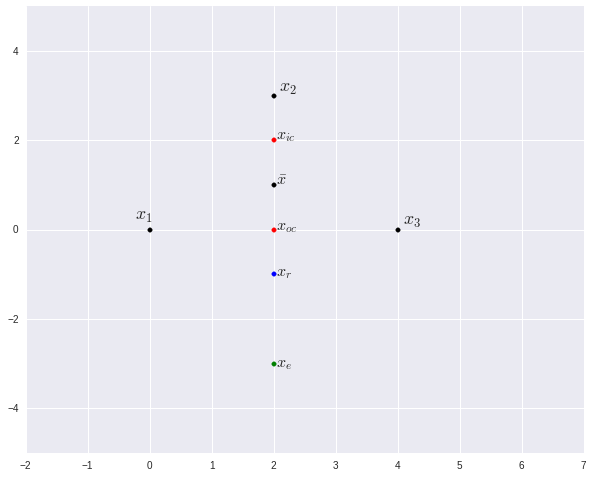

In [5]:
xoc = xbar + gamma*(xr - xbar)
xic = xbar - gamma*(xr - xbar)

ax.scatter(xoc[0], xoc[1], color="r")
ax.scatter(xic[0], xic[1], color="r")
ax.annotate(r"$x_{oc}$", xy=xoc, textcoords='offset points', size=16)
ax.annotate(r"$x_{ic}$", xy=xic, textcoords='offset points', size=16)

fig

### Shrink

The shrink operation takes all but one of the points and draws them closer to that one point.  In the algorithm, we won't be shrinking the points towards the point that we perform the reflection/expansion/contraction on, so we will use $x_1$ as the point towards which the points "shrink."  For every point except $x_1$, we create a new point $x_i^s = x_1 + \delta (x_i - x_1)$.

/home/matthewmckay/anaconda/lib/python3.5/site-packages/matplotlib/text.py:2046: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


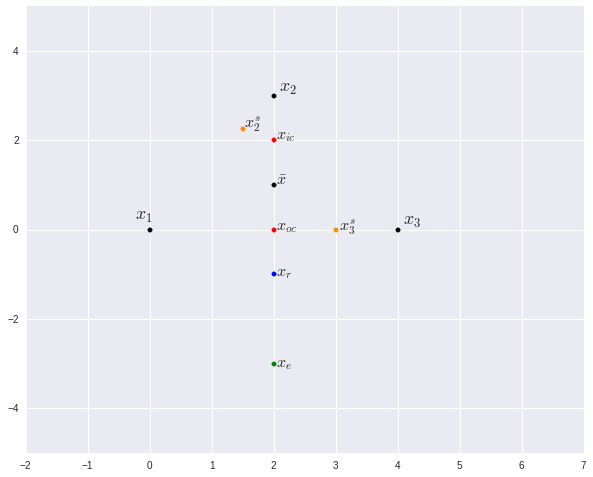

In [6]:
xs2 = x1 + delta*(x2 - x1)
xs3 = x1 + delta*(x3 - x1)

ax.scatter(xs2[0], xs2[1], color="DarkOrange")
ax.scatter(xs3[0], xs3[1], color="DarkOrange")
ax.annotate(r"$x_{2}^s$", xy=xs2, textcoords='offset points', size=16)
ax.annotate(r"$x_{3}^s$", xy=xs3, textcoords='offset points', size=16)

fig

## The Nelder-Mead Algorithm

Now that we understand what each of the 4 operations within the Nelder-Mead algorithm do, we can discuss the actual algorithm.  As you read through the algorithm take note that the main idea is very simple: Order the points, Create some new points, Replace the point with the largest function value, Repeat.


1. There are two ways to obtain the initial simplex.  The first way is to simply pass in a simplex $\Delta$ as the guess.  The second is to pass in a single point, $x_0$, and create the simplex based around that point (we do this by using $x_0$ as one point of the simplex and by using $x_i := x_0 + e_i \varepsilon$ for the $n$ other points).

2. Once we have the simplex, we evaluate the function at each of the points in the simplex and sort the points such that $x_1 \leq x_2 \leq \dots \leq x_{n+1}$ and find $\bar{x} := \frac{1}{n} \sum_{i=1}^n x_i$ (Notice as we mentioned earlier, we are only taking the center point of the $n$ points with smallest function evaluations).  

3. If $|f(\bar{x}) - f(x_1)|$(or another convergence metric of your choosing) then return $x_1$ as the minimum value, otherwise proceed.

4. Create a reflected point $x_r$.

    4.1 If $f(x_1) \leq f(x_r) < f(x_n)$ then replace $x_{n+1}$ with $x_r$
    
    4.2 Return to step 2.

5. Else if $f(x_r) < f(x_1)$ then create the expanded point $x_e$.

    5.1 If $f(x_e) < f(x_r)$ then replace $x_{n+1}$ with $x_e$
    
    5.2 Else if $f(x_r) < f(x_e)$ then replace $x_{n+1}$ with $x_r$.  
    
    5.3 Return to step 2.

6. Else if $f(x_n) < f(x_r) < f(x_{n+1})$ then create the outside contraction point $x_{oc}$.

    6.1 If $f(x_{oc}) < f(x_r)$ then replace $x_{n+1}$ with $x_{oc}$
    
    6.2 Else, shrink the points towards $x_1$
    
    6.3 Return to step 2
    
7. Else if $f(x_{n+1}) < f(x_r)$ then create the inside contraction point $x_{ic}$.

    7.1 If $f(x_{ic}) < f(x_r)$ then replace $x_{n+1}$ with $x_{ic}$
    
    7.2 Else, shrink the points towards $x_1$
    
    7.3 Return to step 2
    

That is the entire algorithm.  As previously stated, you can see that it simply applies our main operations repeatedly until we converge.  I have written a simple implementation of the algorithm below.
    

In [7]:
"""
Author: Chase Coleman
Date: August 13, 2014

This is a simple implementation of the Nelder-Mead algorithm

"""


def nelder_mead(f, x0, method="ANMS", tol=1e-8, maxit=1e4, iter_returns=None):
    """
    This is a naive python implementation of the nelder-mead algorithm.

    Parameters
    ----------

    f : callable
        Function to minimize
    x0 : scalar(float) or array_like(float, ndim=1)
        The initial guess for minimizing
    method : string or tuple(floats)
        If a string, should specify ANMS or NMS then will use specific
        parameter values, but also can pass in a tuple of parameters in
        order (alpha, beta, gamma, delta), which are the reflection,
        expansion, contraction, and contraction parameters
    tol : scalar(float)
        The tolerance level to achieve convergence
    maxit : scalar(int)
        The maximimum number of iterations allowed


    References :

    Nelder, J. A. and R. Mead, "A Simplex Method for Function
    Minimization." 1965. Vol 7(4). Computer Journal

    F. Gao, L. Han, "Implementing the Nelder-Mead simplex algorithm with
    adaptive parameters", Comput. Optim. Appl.,

    http://www.brnt.eu/phd/node10.html#SECTION00622200000000000000


    TODO:
      * Check to see whether we can use an array instead of a list of
      tuples
      * Write some tests
    """
    #-----------------------------------------------------------------#
    # Set some parameter values
    #-----------------------------------------------------------------#
    init_guess = x0
    fx0 = f(x0)
    dist = 10.
    curr_it = 0

    # Get the number of dimensions we are optimizing
    n = np.size(x0)

    # Will use the Adaptive Nelder-Mead Simplex paramters by default
    if method is "ANMS":
        alpha = 1.
        beta = 1. + (2./n)
        gamma = .75 - 1./(2.*n)
        delta = 1. - (1./n)
    # Otherwise can use standard parameters
    elif method is "NMS":
        alpha = 1.
        beta = 2.
        gamma = .5
        delta = .5
    elif type(method) is tuple:
        alpha, beta, gamma, delta = method


    #-----------------------------------------------------------------#
    # Create the simplex points and do the initial sort
    #-----------------------------------------------------------------#
    simplex_points = np.empty((n+1, n))

    pt_fval = [(x0, fx0)]

    simplex_points[0, :] = x0

    for ind, elem in enumerate(x0):

        if np.abs(elem) < 1e-14:
            curr_tau = 0.00025
        else:
            curr_tau = 0.05

        curr_point = np.squeeze(np.eye(1, M=n, k=ind)*curr_tau + x0)

        simplex_points[ind, :] = curr_point
        pt_fval.append((curr_point, f(curr_point)))
        
    if iter_returns is not None:
        ret_points = []
    else:
        ret_points = None


    #-----------------------------------------------------------------#
    # The Core of The Nelder-Mead Algorithm
    #-----------------------------------------------------------------#
    while dist>tol and curr_it<maxit:

        # 1: Sort and find new center point (excluding worst point)
        pt_fval = sorted(pt_fval, key=lambda v: v[1])
        xbar = x0*0

        for i in range(n):
            xbar = xbar + (pt_fval[i][0])/(n)
            
        if iter_returns is not None and curr_it in iter_returns:
            ret_points.append(pt_fval)

        # Define useful variables
        x1, f1 = pt_fval[0]
        xn, fn = pt_fval[n-1]
        xnp1, fnp1 = pt_fval[n]


        # 2: Reflect
        xr = xbar + alpha*(xbar - pt_fval[-1][0])
        fr = f(xr)

        if f1 <= fr < fn:
            # Replace the n+1 point
            xnp1, fnp1 = (xr, fr)
            pt_fval[n] = (xnp1, fnp1)

        elif fr < f1:
            # 3: expand
            xe = xbar + beta*(xr - xbar)
            fe = f(xe)

            if fe < fr:
                xnp1, fnp1 = (xe, fe)
                pt_fval[n] = (xnp1, fnp1)
            else:
                xnp1, fnp1 = (xr, fr)
                pt_fval[n] = (xnp1, fnp1)

        elif fn <= fr <= fnp1:
            # 4: outside contraction
            xoc = xbar + gamma*(xr - xbar)
            foc = f(xoc)

            if foc <= fr:
                xnp1, fnp1 = (xoc, foc)
                pt_fval[n] = (xnp1, fnp1)
            else:
                # 6: Shrink
                for i in range(1, n+1):
                    curr_pt, curr_f = pt_fval[i]
                    # Shrink the points
                    new_pt = x1 + delta*(curr_pt - x1)
                    new_f = f(new_pt)
                    # Replace
                    pt_fval[i] = new_pt, new_f

        elif fr >= fnp1:
            # 5: inside contraction
            xic = xbar - gamma*(xr - xbar)
            fic = f(xic)

            if fic <= fr:
                xnp1, fnp1 = (xic, fic)
                pt_fval[n] = (xnp1, fnp1)
            else:
                # 6: Shrink
                for i in range(1, n+1):
                    curr_pt, curr_f = pt_fval[i]
                    # Shrink the points
                    new_pt = x1 + delta*(curr_pt - x1)
                    new_f = f(new_pt)
                    # Replace
                    pt_fval[i] = new_pt, new_f

        # Compute the distance and increase iteration counter
        dist = abs(fn - f1)
        curr_it = curr_it + 1

    if curr_it == maxit:
        raise ValueError("Max iterations; Convergence failed.")
        
    if ret_points:
        return x1, f1, curr_it, ret_points
    else:
        return x1, f1, curr_it


## Example: Rosenbrock Function

One of the key tests for an optimization algorithm is Rosenbrock's "banana function" which is $f(x, y) := (a - x)^2 + b(y - x^2)^2$ which has a minimum at $(a, a^2)$.  It is a tricky function because of nonconvexities and there are many points that are close to being a minimium.  I graph the function below:

In [8]:
# Define Rosenbrock Function
def rosenbrock(x, a=1, b=100):
    """
    The minimum value of rosenbrock function is
    (a, a**2)
    """
    y = x[1]
    x = x[0]
    return (a - x)**2 + b*(y - x**2)**2

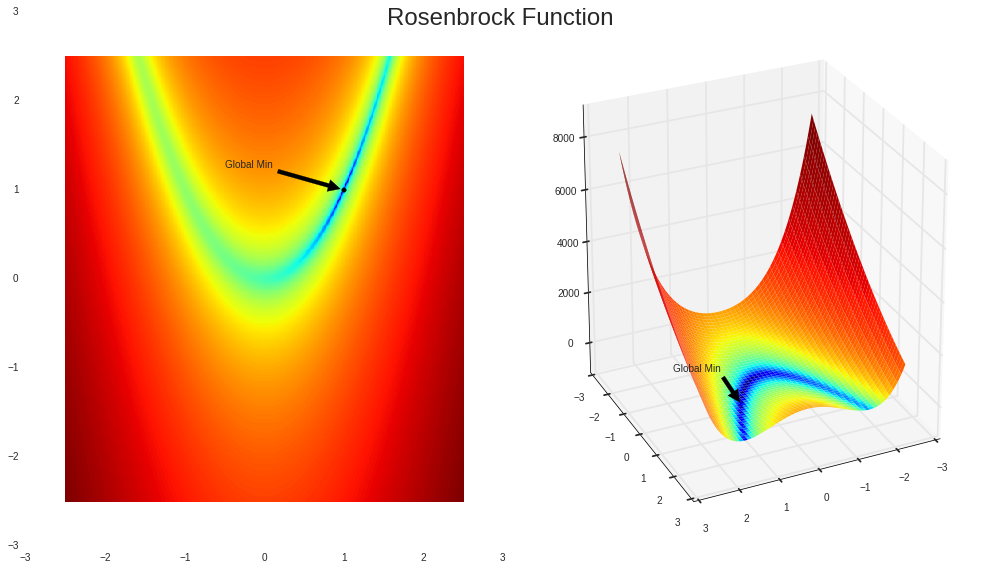

In [9]:
x = np.linspace(-2.5, 2.5, 500)
y = np.linspace(-2.5, 2.5, 500)

X, Y = np.meshgrid(x, y)

Z = rosenbrock([X, Y])

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="3d")

fig.suptitle("Rosenbrock Function", size=24)

# Color mesh
ax1.set_axis_bgcolor("white")
ax1.pcolormesh(X, Y, Z, cmap=matplotlib.cm.jet,
               norm=LogNorm())
ax1.scatter(1, 1, color="k")
ax1.annotate('Global Min', xy=(1, 1), xytext=(-0.5, 1.25),
            arrowprops=dict(facecolor='black', shrink=0.05))

# Surface plot
ax2.set_axis_bgcolor("white")
ax2.plot_surface(X, Y, Z, norm = LogNorm(), cmap=matplotlib.cm.jet,
                 linewidth=0)
ax2.view_init(azim=65, elev=25)
ax2.scatter(1., 1., 0., color="k")
xa, ya, _ = proj3d.proj_transform(1,1,0, ax2.get_proj())
ax2.annotate("Global Min", xy = (xa, ya), xytext = (-20, 30),
    textcoords = 'offset points', ha = 'right', va = 'bottom',
    arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()

# Performance of the Nelder Mead

Now that we have seen the objective function, I will try and use our algorithm to find the minimum of this function.  To show the progress, I will plot some of the steps below --In particular, I will plot iterations 0, 1, 2, 3, 4, 5, 10, 20, 50, 75, 90, and 95 as set by `iterstosee`.

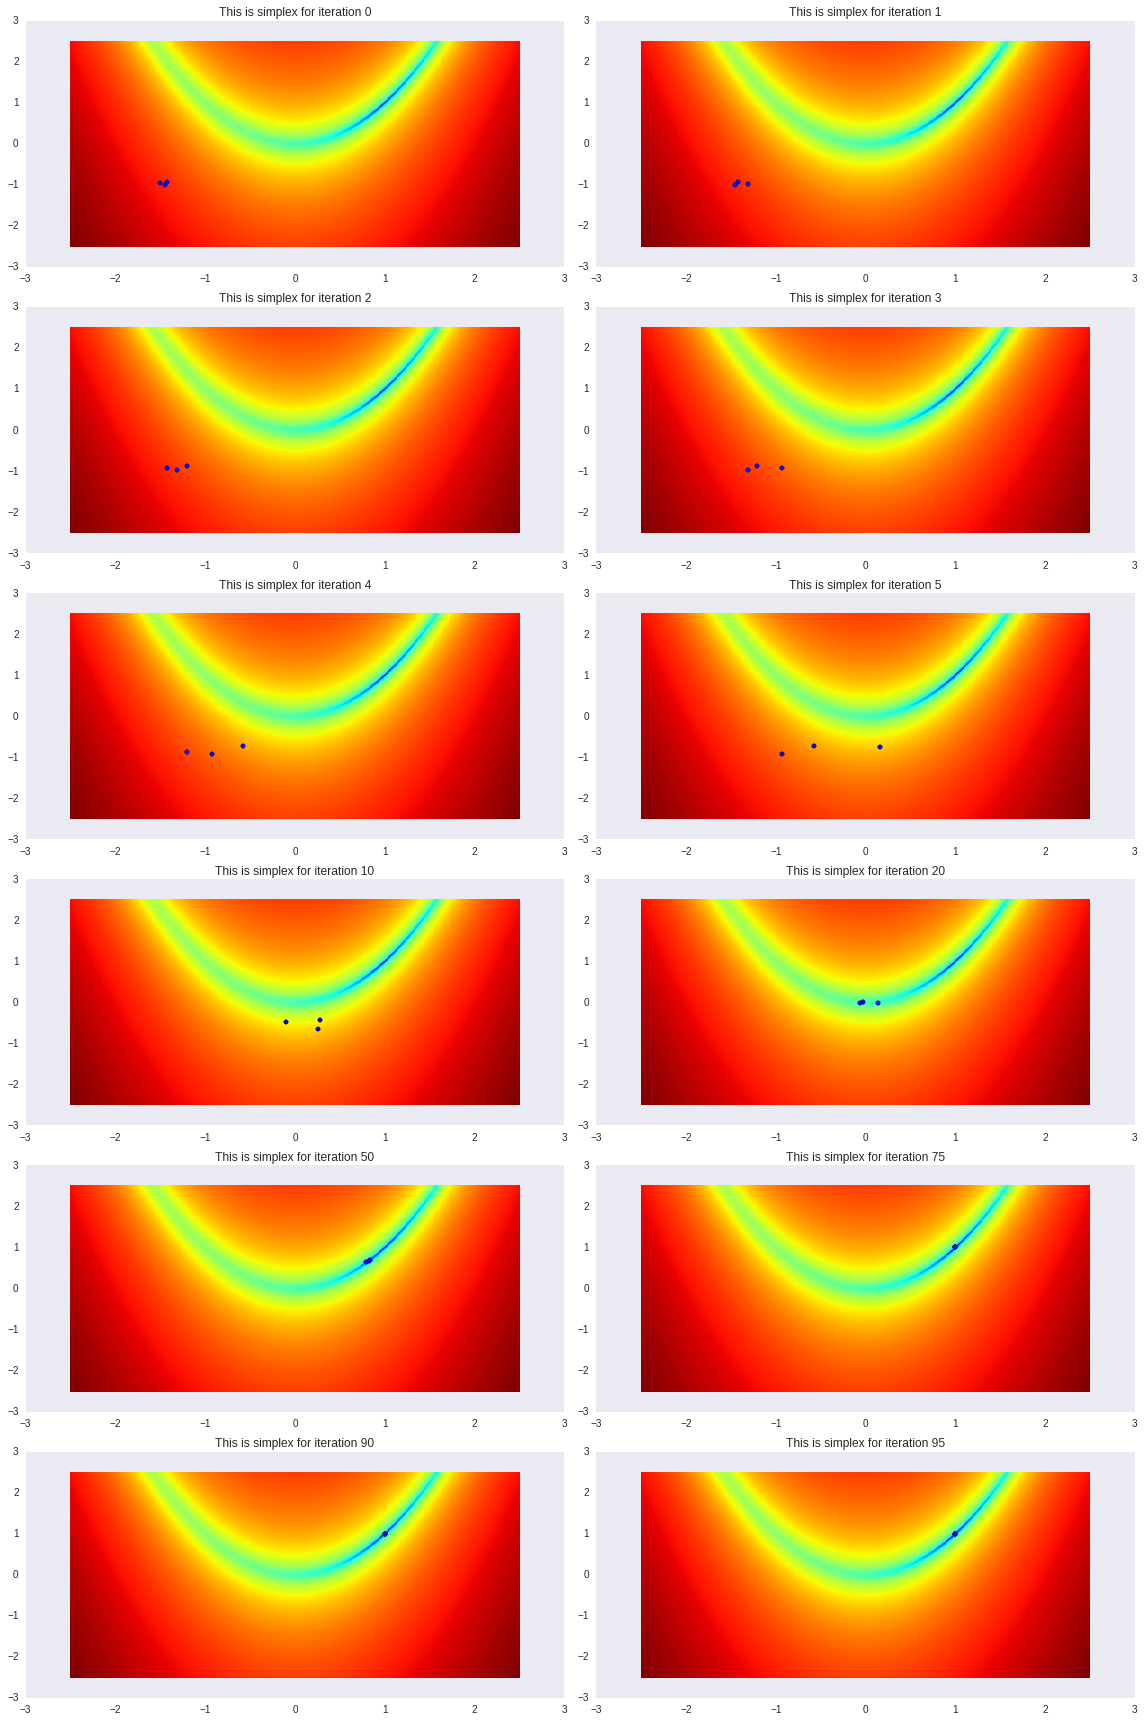

In [10]:
iterstosee = [0, 1, 2, 3, 4, 5, 10, 20, 50, 75, 90, 95]
x, fx, its, ret_tris = nelder_mead(rosenbrock, x0=np.array([-1.5, -1.]), tol=1e-12, iter_returns=iterstosee)

fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(16, 24))
axs = axs.flatten()

# Color mesh
for i, curr_ax in enumerate(axs):
    curr_simplex = np.vstack([ret_tris[i][0][0], ret_tris[i][1][0], ret_tris[i][2][0]])
    curr_ax.pcolormesh(X, Y, Z, cmap=matplotlib.cm.jet,
               norm=LogNorm())
    curr_ax.set_title("This is simplex for iteration %i" %iterstosee[i])
    curr_ax.scatter(curr_simplex[:, 0], curr_simplex[:, 1])

plt.tight_layout()
plt.show()

The minimum value of the Rosenbrock banana function is $f(1, 1) = 0$.  I print the $x$ and $f(x)$ value below.  It seems that our minimization algorithm worked!

In [11]:
printst = "The minimization algorithm converged to x={} with a function value of f(x)={}"
print("\n" + printst.format(x, fx))


The minimization algorithm converged to x=[ 1.00000141  1.00000287] with a function value of f(x)=2.286020259542178e-12
